# Notebook for Training & Tracking Models using NeptuneAI
Here, necessary installations are executed. Also, the data is downloaded and split into test and train set and prepared for further processing.

In [ ]:
!pip install -q gwpy

In [ ]:
%%capture
!pip install torch torchvision
!pip install fastai neptune neptune-fastai --q
#Test
#!pip install pretrainedmodels

In [ ]:
%%capture

# load data set & unzip

!wget https://github.com/felixn95/tds_project/raw/main/wisdatathon2019.zip
!unzip wisdatathon2019.zip
!unzip wisdatathon2019/train_images.zip
!unzip wisdatathon2019/leaderboard_test_data.zip

train_images = '/content/train_images'
test_images =  '/content/leaderboard_test_data'
train_labels = '/content/wisdatathon2019/traininglabels.csv'
test_labels = '/content/wisdatathon2019/testlabels.csv'

The labeled images in the labels csv's do not fit to the image ids, because we need to remove the year at the end of the string in each row.

In [ ]:
import pandas as pd
import os

def adjust_image_ids(input_csv_path, output_csv_path):
    """
    Adjusts the image_ids in the input CSV file by removing the year digits before '.jpg'
    and saves the modified DataFrame to the output CSV path.
    """

    df = pd.read_csv(input_csv_path)

    # Modify the 'image_id' column
    df['image_id'] = df['image_id'].str.replace(r'\d{4}\.jpg', '.jpg', regex=True)

    # Save to the output CSV file
    df.to_csv(output_csv_path, index=False)


adjust_image_ids(train_labels, 'traininglabels_processed.csv')
adjust_image_ids(test_labels, 'testlabels_processed.csv')

train_labels = '/content/traininglabels_processed.csv'
test_labels = '/content/testlabels_processed.csv'

def filter_missing_images(csv_file, image_dir, target_file):
    # Read the CSV file
    df = pd.read_csv(csv_file)

    # Filter out rows where the image file does not exist
    df_filtered = df[df['image_id'].apply(lambda x: os.path.exists(os.path.join(image_dir, x)))]

    # Save the filtered DataFrame
    df_filtered.to_csv(target_file, index=False)

filter_missing_images(train_labels, train_images, '/content/train_labels_filtered.csv')
filter_missing_images(test_labels, test_images, '/content/test_labels_filtered.csv')

train_labels = '/content/train_labels_filtered.csv'
test_labels = '/content/test_labels_filtered.csv'


# Training & Tracking
Here, the datablock is defined. Also necessary imports for training and tracking of the models are executed

In [ ]:
import neptune
import torch
import fastai
from fastai.callback.all import SaveModelCallback
from fastai.vision.all import *
from neptune.integrations.fastai import NeptuneCallback
from neptune.types import File

In [ ]:
# Create Data Block
def get_x(row):
    return os.path.join(train_images, row['image_id'])

def get_y(row):
    return row['has_oilpalm']

# create data block

palm_data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(256),
    batch_tfms=aug_transforms()
)

#Confidence Score <.75 deleted

Here, we clean the dataset from low confidence images to reduce the noise in the dataset. In retrosprective, this was very helpful for the models results, increasing the accuracy by ~1% on average.

In [ ]:
df_train_labels = pd.read_csv(train_labels)
df_train_labels[df_train_labels['score']<0.6]

del train_labels

In [ ]:
filtered_df_train_labels = df_train_labels[df_train_labels['score'] >= 0.75]


# Save the filtered labels to a new CSV file
filtered_labels_path = '/content/filtered_training_labels.csv'
filtered_df_train_labels.to_csv(filtered_labels_path, index=False)


train_labels = '/content/filtered_training_labels.csv'

In [ ]:
filtered_df_train_labels

,image_id,has_oilpalm,score
0,img_00000.jpg,0,0.7895
1,img_00001.jpg,0,1.0000
2,img_00002.jpg,0,1.0000
3,img_00007.jpg,0,1.0000
4,img_00008.jpg,0,1.0000
...,...,...,...
15051,img_10992.jpg,0,0.8107
15052,img_10994.jpg,0,1.0000
15053,img_10995.jpg,0,1.0000
15054,img_10997.jpg,0,1.0000


In [ ]:
# Create filtered Data Loader

dls = palm_data_block.dataloaders(pd.read_csv(filtered_labels_path), bs=64)

In [ ]:
# Available pretrained models from fast.ai
model_set = {
    "resnet18", "resnet34", "resnet50", "resnet101", "resnet152",
    "squeezenet1_0", "squeezenet1_1",
    "densenet121", "densenet169", "densenet201", "densenet161",
    "vgg16_bn", "vgg19_bn",
    "alexnet",
}

#Testing Optimizers
In the following section different optimizers are tested. The results will be further processed later in the notebook. For evaluating the models, no further data augmentation has taken place. Due to the available resources the batch size needs to be adjusted depending on the model.

The results of this optimizer evaluation can be found at [th Github repo](https://)

SGD, Adam, RMSProp(https://arxiv.org/pdf/1910.05446.pdf, https://www.sciencedirect.com/science/article/pii/S2214785321013316)

###1. Modell - Adam

In [ ]:
run_alexnet = neptune.init_run(project='tds-ws23/Sven-models', api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzZWFhNDQ1ZS1mNTI0LTQ3MGUtOTY5MC02NDZlZGE1NmY4NTEifQ==",
                   tags="alexnet")

# Neptune callback object

neptune_cbk = NeptuneCallback(run=run_alexnet)

# Create a fast ai learner and pass the model and NeptuneCallback parameters including the specific run

alexnet_learner = cnn_learner(dls, alexnet, cbs=[neptune_cbk], metrics=accuracy, opt_func=Adam)



https://app.neptune.ai/tds-ws23/Sven-models/e/SVEN-100


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 93.9MB/s]


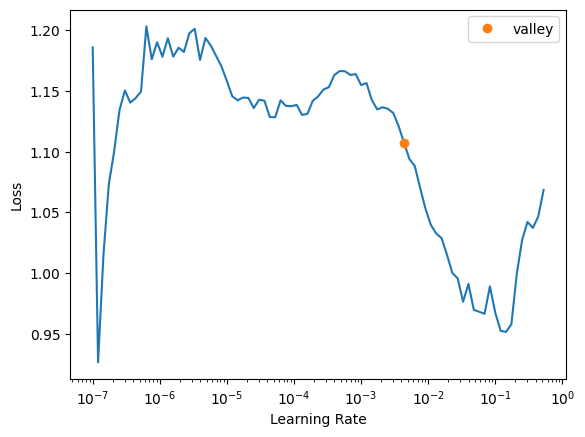

In [ ]:
current_lr = alexnet_learner.lr_find()

In [ ]:
# run for 10 epochs
alexnet_learner.fit_one_cycle(10, lr_max=current_lr, cbs=[EarlyStoppingCallback(monitor='accuracy', patience=2, comp=np.greater)])

epoch,train_loss,valid_loss,accuracy,time
0,0.338121,0.299636,0.930588,01:03
1,0.274967,0.315489,0.929924,01:05
2,0.249928,0.225047,0.929924,01:16


No improvement since epoch 0: early stopping


In [ ]:
#Delete Cuda Cache
del alexnet_learner,

torch.cuda.empty_cache()

### 2. Modell - RMSProp

In [ ]:
run_alexnet = neptune.init_run(project='tds-ws23/Sven-models', api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzZWFhNDQ1ZS1mNTI0LTQ3MGUtOTY5MC02NDZlZGE1NmY4NTEifQ==",
                   tags="alexnet")

# Neptune callback object

neptune_cbk = NeptuneCallback(run=run_alexnet)

# Create a fast ai learner and pass the model and NeptuneCallback parameters including the specific run

alexnet_learner = cnn_learner(dls, alexnet, cbs=[neptune_cbk], metrics=accuracy, opt_func=RMSProp)

https://app.neptune.ai/tds-ws23/Sven-models/e/SVEN-101


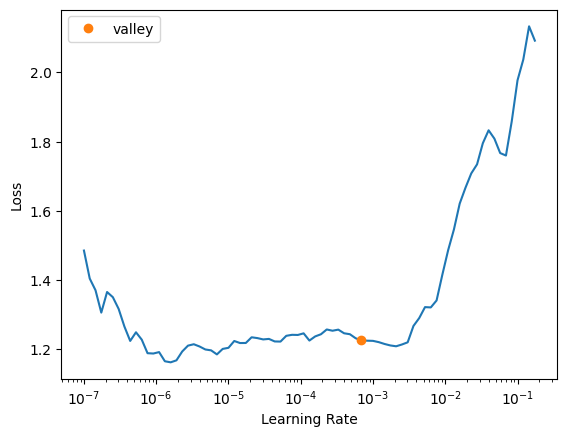

In [ ]:
current_lr = alexnet_learner.lr_find()

In [ ]:
# run for 10 epochs
alexnet_learner.fit_one_cycle(10, lr_max=current_lr, cbs=[EarlyStoppingCallback(monitor='accuracy', patience=2, comp=np.greater)])

epoch,train_loss,valid_loss,accuracy,time
0,0.686368,0.353993,0.908004,01:06
1,0.289190,0.255995,0.929259,01:04
2,0.252059,0.239046,0.932581,01:07
3,0.237784,0.214554,0.929591,01:04
4,0.207749,0.215028,0.928927,01:03


No improvement since epoch 2: early stopping


In [ ]:
#Delete Cuda Cache
del alexnet_learner,

torch.cuda.empty_cache()

###3. Modell - SGD

In [ ]:
run_alexnet = neptune.init_run(project='tds-ws23/Sven-models', api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzZWFhNDQ1ZS1mNTI0LTQ3MGUtOTY5MC02NDZlZGE1NmY4NTEifQ==",
                   tags="alexnet")

# Neptune callback object

neptune_cbk = NeptuneCallback(run=run_alexnet)

# Create a fast ai learner and pass the model and NeptuneCallback parameters including the specific run

alexnet_learner = cnn_learner(dls, alexnet, cbs=[neptune_cbk], metrics=accuracy, opt_func=SGD)


https://app.neptune.ai/tds-ws23/Sven-models/e/SVEN-109


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 149MB/s]


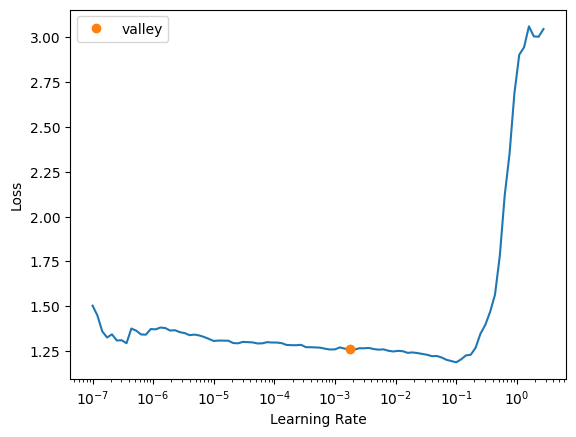

In [ ]:
current_lr = alexnet_learner.lr_find()

In [ ]:
# run for 10 epochs
alexnet_learner.fit_one_cycle(10, lr_max=current_lr, cbs=[EarlyStoppingCallback(monitor='accuracy', patience=2, comp=np.greater)])

epoch,train_loss,valid_loss,accuracy,time
0,1.069393,0.666958,0.700100,01:06
1,0.655836,0.444179,0.885088,01:02
2,0.438423,0.325741,0.914314,01:04
3,0.378327,0.272685,0.927599,01:02
4,0.334146,0.249175,0.929259,01:05
5,0.289020,0.243430,0.929591,01:07
6,0.309627,0.231152,0.931916,01:05
7,0.300865,0.231802,0.930256,01:06
8,0.313665,0.226905,0.930920,01:09


No improvement since epoch 6: early stopping


In [ ]:
#Delete Cuda Cache
alexnet_learner,

torch.cuda.empty_cache()

#Best Models with augmented Data Set

In this section the best performing models are optimized using an augmented Dataset as described above.

##1. Densenet121 with Adam
*   Batch size: 64
*   former Accuracy: 93,52%

-->new Accuracy: 94,39%


In [ ]:
run_densenet121 = neptune.init_run(project='tds-ws23/Sven-models', api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzZWFhNDQ1ZS1mNTI0LTQ3MGUtOTY5MC02NDZlZGE1NmY4NTEifQ==",
                   tags="best_models")

# Neptune callback object

neptune_cbk = NeptuneCallback(run=run_densenet121)

# Create a fast ai learner and pass the model and NeptuneCallback parameters including the specific run

densenet121_learner = cnn_learner(dls, densenet121, cbs=[neptune_cbk], metrics=accuracy, opt_func=Adam)


https://app.neptune.ai/tds-ws23/Sven-models/e/SVEN-108


/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.10/dist-packages/neptune_fastai/impl/__init__.py:247: UserWarning: NeptuneCallback: SaveModelCallback is necessary for uploading model checkpoints.
  warnings.warn("NeptuneCallback: SaveModelCallback is necessary for uploading model checkpoints.")


In [ ]:
%%capture
current_lr = densenet121_learner.lr_find()

In [ ]:
densenet121_learner.fit_one_cycle(10, lr_max=current_lr, cbs=[EarlyStoppingCallback(monitor='accuracy', patience=4, comp=np.greater)])

epoch,train_loss,valid_loss,accuracy,time
0,0.673811,0.337820,0.914476,02:14
1,0.260987,0.218364,0.942166,02:13
2,0.246180,0.208309,0.941115,02:14
3,0.243140,0.191308,0.943568,02:13
4,0.221105,0.187240,0.935506,02:13
5,0.210370,0.182424,0.935156,02:20
6,0.188678,0.189006,0.943919,02:16
7,0.201031,0.176547,0.939713,02:15
8,0.185754,0.174588,0.937960,02:19
9,0.191690,0.174870,0.937610,02:19


In [ ]:
#Delete Cuda Cache
del densenet121_learner,

torch.cuda.empty_cache()

##2. Densenet169 with Adam
*   Batch size: 64
*   former Accuracy: 93,32%

-->new Accuracy: 94,35%

In [ ]:
run_densenet169 = neptune.init_run(project='tds-ws23/Sven-models', api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzZWFhNDQ1ZS1mNTI0LTQ3MGUtOTY5MC02NDZlZGE1NmY4NTEifQ==",
                   tags="best_models")

# Neptune callback object

neptune_cbk = NeptuneCallback(run=run_densenet169)

# Create a fast ai learner and pass the model and NeptuneCallback parameters including the specific run

densenet169_learner = cnn_learner(dls, densenet169, cbs=[neptune_cbk], metrics=accuracy, opt_func=Adam)

https://app.neptune.ai/tds-ws23/Sven-models/e/SVEN-104


/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 143MB/s]
/usr/local/lib/python3.10/dist-packages/neptune_fastai/impl/__init__.py:247: UserWarning: NeptuneCallback: SaveModelCallback is necessary for uploading model checkpoints.
  warnings.warn("NeptuneCallback: SaveModelCallback is necessary for uploading model checkpoints.")


In [ ]:
%%capture
current_lr = densenet169_learner.lr_find()

In [ ]:
densenet169_learner.fit_one_cycle(10, lr_max=current_lr, cbs=[EarlyStoppingCallback(monitor='accuracy', patience=4, comp=np.greater)])

epoch,train_loss,valid_loss,accuracy,time
0,0.803018,0.515519,0.766562,02:47
1,0.302542,0.218109,0.942867,02:47
2,0.255963,0.190451,0.939012,02:44
3,0.217893,0.186371,0.943568,02:40
4,0.209881,0.194514,0.933403,02:40
5,0.188944,0.174190,0.942867,02:41
6,0.187719,0.176769,0.938311,02:41
7,0.181120,0.175864,0.937259,02:41


No improvement since epoch 3: early stopping


In [ ]:
#Delete Cuda Cache
del densenet169_learner,

torch.cuda.empty_cache()

##3.1 Squeezenet1_0 with Adam
*   Batch size: 64
*   former Accuracy: 93,12%
-->new Accuracy: 94,39%

In [ ]:
%%capture
run_Squeezenet1_0 = neptune.init_run(project='tds-ws23/Sven-models', api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzZWFhNDQ1ZS1mNTI0LTQ3MGUtOTY5MC02NDZlZGE1NmY4NTEifQ==",
                   tags="best_models")

# Neptune callback object

neptune_cbk = NeptuneCallback(run=run_Squeezenet1_0)

# Create a fast ai learner and pass the model and NeptuneCallback parameters including the specific run

squeezenet1_0_learner = cnn_learner(dls, squeezenet1_0, cbs=[neptune_cbk], metrics=accuracy, opt_func=Adam)

In [ ]:
%%capture
current_lr = squeezenet1_0_learner.lr_find()

In [ ]:
squeezenet1_0_learner.fit_one_cycle(10, lr_max=current_lr, cbs=[EarlyStoppingCallback(monitor='accuracy', patience=4, comp=np.greater)])

epoch,train_loss,valid_loss,accuracy,time
0,0.504321,0.253576,0.929548,01:00
1,0.266003,0.203016,0.938311,00:58
2,0.256325,0.226205,0.937259,00:59
3,0.245255,0.209706,0.943218,00:55
4,0.217314,0.214381,0.934104,00:54
5,0.221629,0.192349,0.943919,00:51
6,0.195917,0.178902,0.943218,00:56
7,0.193847,0.182146,0.939012,01:03
8,0.176939,0.180718,0.941465,00:52
9,0.182754,0.179178,0.942166,00:58


No improvement since epoch 5: early stopping


In [ ]:
 #Delete Cuda Cache
del squeezenet1_0_learner,

torch.cuda.empty_cache()

##3.2 Squeezenet1_1 with SGD
*   Batch size: 64
*   former Accuracy: 93,12%
--> new Accuracy: 93,55%

In [ ]:
run_Squeezenet1_1 = neptune.init_run(project='tds-ws23/Sven-models', api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzZWFhNDQ1ZS1mNTI0LTQ3MGUtOTY5MC02NDZlZGE1NmY4NTEifQ==",
                   tags="best_models")

# Neptune callback object

neptune_cbk = NeptuneCallback(run=run_Squeezenet1_1)

# Create a fast ai learner and pass the model and NeptuneCallback parameters including the specific run

squeezenet1_1_learner = cnn_learner(dls, squeezenet1_1, cbs=[neptune_cbk], metrics=accuracy, opt_func=SGD)

https://app.neptune.ai/tds-ws23/Sven-models/e/SVEN-107


/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 60.1MB/s]
/usr/local/lib/python3.10/dist-packages/neptune_fastai/impl/__init__.py:247: UserWarning: NeptuneCallback: SaveModelCallback is necessary for uploading model checkpoints.
  warnings.warn("NeptuneCallback: SaveModelCallback is necessary for uploading model checkpoints.")


In [ ]:
%%capture
current_lr = squeezenet1_1_learner.lr_find()

In [ ]:
squeezenet1_1_learner.fit_one_cycle(10, lr_max=current_lr, cbs=[EarlyStoppingCallback(monitor='accuracy', patience=4, comp=np.greater)])

epoch,train_loss,valid_loss,accuracy,time
0,1.123092,0.783851,0.631966,00:54
1,0.797571,0.484931,0.853137,01:02
2,0.566179,0.353883,0.901507,00:51
3,0.438420,0.301508,0.926043,00:50
4,0.398295,0.267344,0.929898,00:52
5,0.364262,0.242340,0.933403,00:49
6,0.346422,0.232684,0.935156,00:49
7,0.327858,0.230996,0.934805,00:52
8,0.329000,0.228364,0.934805,00:49
9,0.313539,0.230024,0.935506,00:49


In [ ]:
#Delete Cuda Cache
del squeezenet1_1_learner,

torch.cuda.empty_cache()